In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
import mkl
mkl.set_num_threads(1)

testing = True # TODO: run in testing mode (fast)

In [3]:
# Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# - this might take several minutes, so run these only if you haven't done so before.

# load IceCube's effective area and rotate it to approximate other detectors
## %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
## %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
## %run ../../core/resolution.py 
#--renew_calc if you want to repeat the resolution generation (takes a few minutes)

# gather all ingredients and save them as unified 'mephistogram' data structure
## %run ../../core/prepare_histograms.py

# Imports

In [4]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from matplotlib.colors import LogNorm
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm, percentileofscore, gamma
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from fluxes import PL_flux, PLcut_flux, model_flux
from tqdm import tqdm

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [5]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background


In [7]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


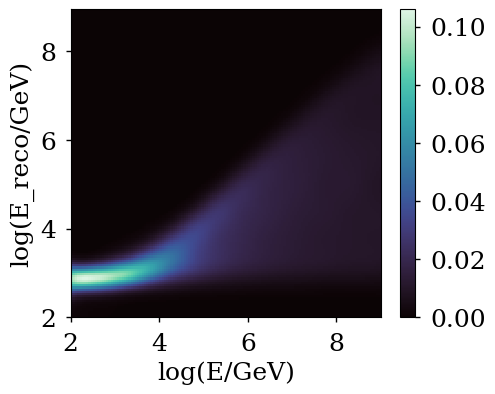

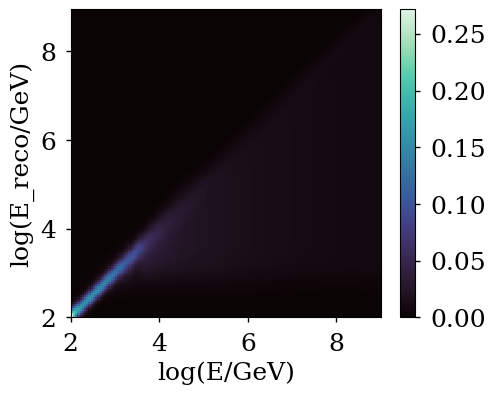

In [9]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

Text(0.5, 1.0, 'Baseline energy resolution')

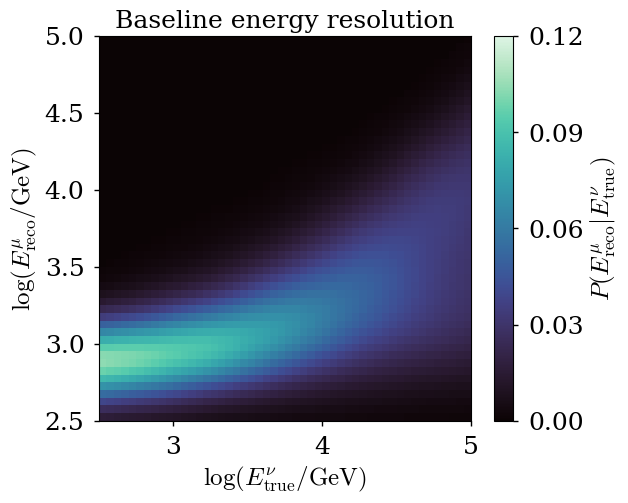

In [10]:
# nice plot
ebounds = (2.5, 5)

f, ax = plt.subplots(figsize=(6, 5))
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=ax, vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [11]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# NGC1068 source parameters

In [12]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [13]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [14]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~87

ngc 1068: 87.49686772537285


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# NGC 1068
## Significance test Background vs. Background + Signal

In [15]:
detector_keys = ["IceCube"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres=baseline_eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06720854]
Signal fit parameters: [1.  1.  3.2]
TS check: -306963.2039092822 (fit:  -306963.2039092822 )
-2 Delta LLH: 19.733658471086528
P-VALUE: 5.18669259666666e-05 SIGNIFICANCE: 3.8816881413065385



# Model fit disk corona Kheirandish

In [16]:
from fluxes import disk_corona_flux, kheirandish_src_flux

## combined plot

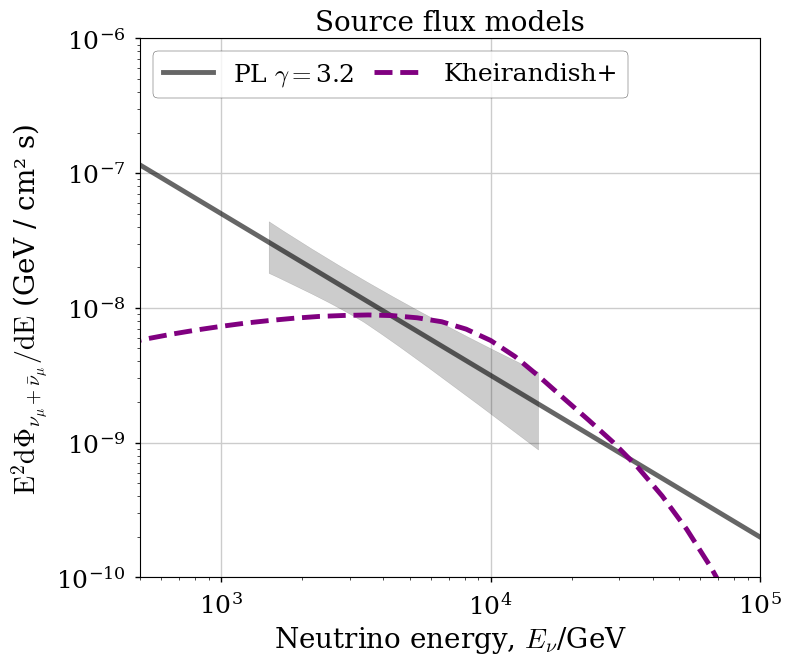

In [17]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

f, ax = plt.subplots(figsize=(8, 7))
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=0.6,
    lw=3.5,
)

ax.set_yscale("log")
ax.set_ylabel(
    r"$\rm E^2 d\Phi_{\nu_\mu + \bar{\nu}_\mu} / dE$ (GeV / cm² s)", fontsize=fontsize
)
ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(5e2, 1e5)


ax.plot(
    x_evals, 
    10**(kheirandish_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="purple",
    ls="--",
    label="Kheirandish+",
    lw=3.5,
)

ax.legend(
    frameon=True,
    loc="upper left",
    ncols=2,
    bbox_to_anchor=(0, 1.0),
    columnspacing=0.8,
    edgecolor="k",
)


## event numbers

In [18]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=kheirandish_src_flux,
)
print(np.sum(k_s))

35.26391943047457


## model fit

In [19]:
## direct fit of kheirandish model (normalization only)

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=kheirandish_src_flux,
    )

    dct = dict(
        shape="model_flux",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=None,  # parameter not used
        phi_0=None,  # parameter not used
        flux_shape=kheirandish_src_flux,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    ts_check = global_llh((1, 1))
    print(f"TS check: {ts_check}, fit: {out_comp[1]}, diff: {ts_check - out_comp[1]}")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print(
        "Check P-VALUE:",
        chi2.sf(out_bckg[1] - ts_check, 1),
        "SIGNIFICANCE:",
        norm.isf(chi2.sf(out_bckg[1] - ts_check, 1)),
    )
    print()

IceCube
Atmo-only normalization: [1.02708958]
Signal fit parameters: [1.00000466 0.9996765 ]
TS check: -286683.2886522887, fit: -286683.2886514083, diff: -8.80449078977108e-07
-2 Delta LLH: 13.561768771673087
P-VALUE: 0.00023083946191671464 SIGNIFICANCE: 3.502058104010598
Check P-VALUE: 0.0002308393536349395 SIGNIFICANCE: 3.5020582289871096

Plenum-1
Atmo-only normalization: [1.03399962]
Signal fit parameters: [1.00003715 0.99945205]
TS check: -1298783.387571576, fit: -1298783.387557747, diff: -1.3828976079821587e-05
-2 Delta LLH: 71.02985715540126
P-VALUE: 3.518596134952987e-17 SIGNIFICANCE: 8.346405461846748
Check P-VALUE: 3.518571472254613e-17 SIGNIFICANCE: 8.346406290071593

Plenum-2
Atmo-only normalization: [1.02930809]
Signal fit parameters: [1.00002034 0.99981691]
TS check: -1253530.9963802425, fit: -1253530.9963738653, diff: -6.377231329679489e-06
-2 Delta LLH: 159.307265331503
P-VALUE: 1.6032620361566805e-36 SIGNIFICANCE: 12.567002447854586
Check P-VALUE: 1.6032568922791667e-3

## fit PL

In [58]:
## powerlaw fit of kheirandish model
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=kheirandish_src_flux,
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_pl_kheirandish = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_pl_kheirandish[0])
    print(
        "TS check:",
        global_llh((1, 1, ngc_flux.gamma)),
        "(fit: ",
        out_pl_kheirandish[1],
        ")",
    )
    print("-2 Delta LLH:", out_bckg[1] - out_pl_kheirandish[1])

    pval = chi2.sf(out_bckg[1] - out_pl_kheirandish[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.02709129]
Signal fit parameters: [0.99363203 0.39761892 2.82394868]
TS check: -286675.55591699615 (fit:  -286681.9511589033 )
-2 Delta LLH: 12.224276269436814
P-VALUE: 0.002215808048153181 SIGNIFICANCE: 2.8456839081131284

Plenum-1
Atmo-only normalization: [1.03399754]
Signal fit parameters: [0.99236499 0.35687207 2.7638655 ]
TS check: -1298736.2314018907 (fit:  -1298777.3925896373 )
-2 Delta LLH: 65.03488908871077
P-VALUE: 7.54837154471804e-15 SIGNIFICANCE: 7.6867094641034095

Plenum-2
Atmo-only normalization: [1.02930774]
Signal fit parameters: [0.99346051 0.37834307 2.79887931]
TS check: -1253433.5774311554 (fit:  -1253516.1355537223 )
-2 Delta LLH: 144.4464451854583
P-VALUE: 4.3038087354404075e-32 SIGNIFICANCE: 11.733262118318915



In [59]:
# (approximate) PL result if truth is DC model
ngc_pl0_flux = PL_flux(PHI_NGC * 0.38, 2.8, E0_NGC, "powerlaw")

# fit mixture model

In [60]:
# define mixture fluxes
kheirandish_mixture = model_flux(
    kheirandish_src_flux.norm,  # baseline model flux
    kheirandish_src_flux.model_spline,
    kheirandish_src_flux.shape,
)


In [64]:
ident="IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s_kh = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=kheirandish_mixture,
)

print(k_s_kh.sum())
k_s_pl = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print(k_s_pl.sum())
diff = k_s_pl.sum() - k_s_kh.sum()
print("diff", diff)
factor = diff/ k_s_pl.sum()
print(factor)

ngc_PL_mixture = PL_flux(
    ngc_flux.norm * factor, ngc_flux.gamma, ngc_flux.E0, ngc_flux.shape
)

# roughly yields same number of events in the end

k_s_pl_mix = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_PL_mixture,
)
print(k_s_pl_mix.sum())
print()



35.26391943047457
87.49686772537285
diff 52.23294829489828
0.5969693504782625
52.23294829489827



(2.0, 6.0)

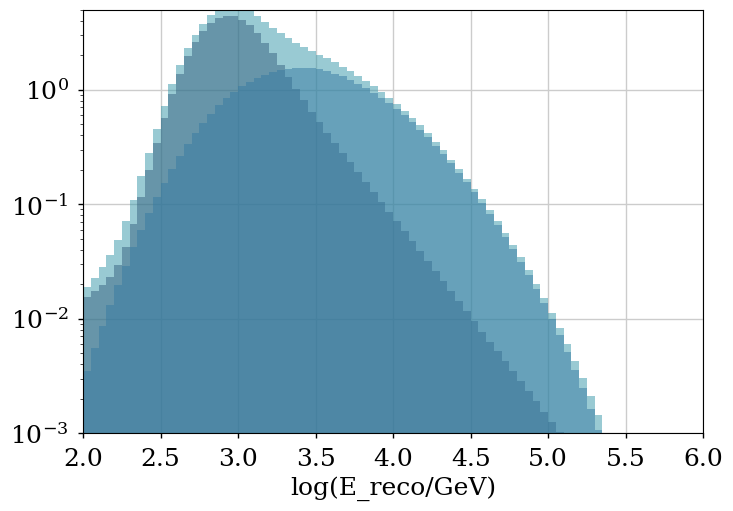

In [65]:
f, ax = plt.subplots()
k_s_pl_mix.sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)
k_s_kh.sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)
(k_s_pl_mix + k_s_kh).sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)


plt.yscale("log")
plt.ylim(1e-3, 5)
plt.xlim(2, 6)

In [56]:
## fit model + powerlaw mixture model

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=[kheirandish_mixture, ngc_PL_mixture],
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=st.E0_NGC,  # parameter not used
        phi_0=st.PHI_NGC,  # parameter not used
        flux_shape=kheirandish_src_flux,
        shape=["model_flux", "powerlaw"],
        signal_parameters=[1, 2],  # for each of the models
    )

    # fix signal normalization to 0
    ndof = 3  # for p-value calculation
    local_llh = lambda x: ps_llh_multi((x[0], 0, 0, 2), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1, 1.1, 3.3),
        bounds=[
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    ts_check = global_llh((1, 1, 1, st.GAMMA_NGC))
    print(f"TS check: {ts_check}, fit: {out_comp[1]}, diff: {ts_check - out_comp[1]}")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], ndof)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print(
        "Check P-VALUE:",
        chi2.sf(out_bckg[1] - ts_check, ndof),
        "SIGNIFICANCE:",
        norm.isf(chi2.sf(out_bckg[1] - ts_check, ndof)),
    )
    print()

IceCube
Atmo-only normalization: [1.06741706]
Signal fit parameters: [0.99965965 0.85196172 0.65260686 3.13711819]
TS check: -282945.12962015846, fit: -282947.7020998716, diff: 2.5724797131260857
-2 Delta LLH: 33.45625663839746
P-VALUE: 2.580407865064666e-07 SIGNIFICANCE: 5.020235542991706
Check P-VALUE: 8.99318594368191e-07 SIGNIFICANCE: 4.774824859256758

Plenum-1
Atmo-only normalization: [1.08935216]
Signal fit parameters: [0.99999826 0.99701576 0.60116663 3.19907673]
TS check: -1279040.4302699557, fit: -1279054.0162625888, diff: 13.585992633132264
-2 Delta LLH: 175.9658231420908
P-VALUE: 6.555541736629024e-38 SIGNIFICANCE: 12.81734666275762
Check P-VALUE: 5.617255816319368e-35 SIGNIFICANCE: 12.282588620001702

Plenum-2
Atmo-only normalization: [1.07446033]
Signal fit parameters: [0.99998432 0.99917035 0.60015742 3.19984586]
TS check: -1233771.215774168, fit: -1233801.6250858097, diff: 30.409311641706154
-2 Delta LLH: 394.7473978619091
P-VALUE: 3.040096810911722e-85 SIGNIFICANCE: 19

In [57]:
## model + powerlaw mixture model, but fit with PL as cross check

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=[kheirandish_mixture, ngc_PL_mixture],
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=st.E0_NGC,  # parameter not used
        phi_0=st.PHI_NGC,  # parameter not used
        shape="powerlaw",
    )

    # fix signal normalization to 0
    ndof = 3  # for p-value calculation
    local_llh = lambda x: ps_llh_multi((x[0], 0, 2), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1, 3.3),
        bounds=[
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    
    pval = chi2.sf(out_bckg[1] - out_comp[1], ndof)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

    print()

IceCube
Atmo-only normalization: [1.06741706]
Signal fit parameters: [0.99771802 0.93211291 2.96077841]
P-VALUE: 3.639796468881818e-07 SIGNIFICANCE: 4.953752123504758

Plenum-1
Atmo-only normalization: [1.08935216]
Signal fit parameters: [0.99787787 0.9089687  2.94036949]
P-VALUE: 2.743590009535762e-37 SIGNIFICANCE: 12.705847403268386

Plenum-2
Atmo-only normalization: [1.07446033]
Signal fit parameters: [0.99789653 0.92086829 2.95199094]
P-VALUE: 1.3658906373293505e-83 SIGNIFICANCE: 19.33490358157586



# Power law vs. Model fit


In [157]:
from scipy.stats import poisson
from mephisto import like

In [158]:
def generate_random_data(k):
    PE = []
    for ki in k:
        meph_i = like(ki, fill_value=0)
        meph_i.histo = poisson.rvs(ki.histo)
        PE.append(meph_i)
    return PE

In [173]:
## PL as truth compared to kheirandish model fit
TS_pl_as_H0_kh = []
asimov_fits = []
detector_keys = ["IceCube" , "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)
    # 1) baseline DC (kheirandish) model for fit
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=kheirandish_src_flux,
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_pl0_flux.E0,
        phi_0=ngc_pl0_flux.norm,
    )

    # fit different models to asimov data
    local_llh = lambda x: ps_llh_multi(
        (x[0], 0), shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )
    pl_llh = lambda x: ps_llh_multi(x, shape="powerlaw", flux_shape=ngc_pl0_flux, **dct)
    global_llh = lambda x: ps_llh_multi(
        x, shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )

    out_pl = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, 3),
        approx_grad=True,
    )
    print("PL fit:", out_pl[0])

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_kheirandish = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_kheirandish[0])
    print(
        "TS check:",
        global_llh((1, 1)),
        "(fit: ",
        out_kheirandish[1],
        ")",
    )
    print("-2 Delta LLH (to atmo):", out_bckg[1] - out_kheirandish[1])

    pval = chi2.sf(out_bckg[1] - out_kheirandish[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

    # 2) generate pseudo experiments
    # ... based on PL asimov data
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=ngc_pl0_flux,  # PL flux as truth
    )
    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_pl0_flux.E0,
        phi_0=ngc_pl0_flux.norm,
    )
    # fit asimov data for comparison to PE
    pl_llh = lambda x: ps_llh_multi(x, shape="powerlaw", flux_shape=ngc_pl0_flux, **dct)
    global_llh = lambda x: ps_llh_multi(
        x, shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )

    out_pl_truthAsimov = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, 3),
        approx_grad=True,
    )
    out_kheirandish_truthAsimov = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    asimov_fits.append(
        {
            "TS_PL_model_truthAsimov": out_pl_truthAsimov[1]
            - out_kheirandish_truthAsimov[1],
            "TS_PL_model": out_pl[1] - out_kheirandish[1],
            "TS_PL_atm": out_bckg[1] - out_pl[1],
            "TS_atm_model": out_bckg[1] - out_kheirandish[1],
            "atm_bg_norm": out_bckg[0][0],
            "pl_bg_norm": out_pl[0][0],
            "pl_norm": out_pl[0][1],
            "pl_gamma": out_pl[0][2],
            "model_bg": out_kheirandish[0][0],
            "model_norm": out_kheirandish[0][1],
            "ident": key,
            "truth": kheirandish_src_flux.shape,
        }
    )
    # 3) fit pseudo experiments
    for _ in range(100*3):

        PE = generate_random_data(all_k)
        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=PE,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_pl0_flux.E0,  # parameter not used for model
            phi_0=ngc_pl0_flux.norm,  # parameter not used for model
        )

        # fix signal normalization to 0
        local_llh = lambda x: ps_llh_multi(
            (x[0], 0), flux_shape=kheirandish_src_flux, shape="model_flux", **dct
        )
        pl_llh = lambda x: ps_llh_multi(x, flux_shape=ngc_pl0_flux, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_multi(
            x, flux_shape=kheirandish_src_flux, shape="model_flux", **dct
        )

        out_bckg_pe = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1,),
            approx_grad=True,
        )

        out_pl_pe = fmin_l_bfgs_b(
            pl_llh,
            x0=(1, 1, 2.7),
            bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
            approx_grad=True,
        )
        if out_pl_pe[2]["warnflag"] != 0:
            continue

        out_kheirandish_pe = fmin_l_bfgs_b(
            global_llh,
            x0=(1.1, 1.1),
            bounds=[(1e-3, 10), (1e-3, 10)],
            approx_grad=True,
        )
        if out_kheirandish_pe[2]["warnflag"] != 0:
            continue

        TS_pl_as_H0_kh.append(
            {
                "TS_PL_model": out_pl_pe[1] - out_kheirandish_pe[1],
                "TS_PL_atm": out_bckg_pe[1] - out_pl_pe[1],
                "TS_atm_model": out_bckg_pe[1] - out_kheirandish_pe[1],
                "atm_bg_norm": out_bckg_pe[0][0],
                "pl_bg_norm": out_pl_pe[0][0],
                "pl_norm": out_pl_pe[0][1],
                "pl_gamma": out_pl_pe[0][2],
                "model_bg": out_kheirandish_pe[0][0],
                "model_norm": out_kheirandish_pe[0][1],
                "ident": key,
                "truth": ngc_pl0_flux.shape,
            }
        )
TS_pl_as_H0_kh = pd.DataFrame(TS_pl_as_H0_kh)
asimov_fits = pd.DataFrame(asimov_fits)

IceCube
PL fit: [0.99336756 1.058322   2.82795028]
Atmo-only normalization: [1.02709129]
Signal fit parameters: [1. 1.]
TS check: -286683.2886522887 (fit:  -286683.2886522887 )
-2 Delta LLH (to atmo): 13.561769654857926
P-VALUE: 0.0011352699357976598 SIGNIFICANCE: 3.052354222338454

Plenum-1
PL fit: [0.99252757 0.93912614 2.76465809]
Atmo-only normalization: [1.03399754]
Signal fit parameters: [1. 1.]
TS check: -1298783.387571576 (fit:  -1298783.387571576 )
-2 Delta LLH (to atmo): 71.02987102745101
P-VALUE: 3.767553961010667e-16 SIGNIFICANCE: 8.061520783795562

Plenum-2
PL fit: [0.99225164 1.0554004  2.81908886]
Atmo-only normalization: [1.02930774]
Signal fit parameters: [1. 1.]
TS check: -1253530.9963802425 (fit:  -1253530.9963802425 )
-2 Delta LLH (to atmo): 159.30727170570754
P-VALUE: 2.551910774593735e-35 SIGNIFICANCE: 12.346245516800353



In [131]:
TS_pl_as_H0_kh.to_pickle(join(LOCALPATH, "ModelvsPL_fits_PE.pickle"))
asimov_fits.to_pickle(join(LOCALPATH, "ModelvsPL_fits_asimov.pickle"))

In [174]:
asimov_fits.set_index("ident", inplace=True)


IceCube 0.10999999999999999 0.1341125248643331 1.1071593255513383
Plenum-1 0.0033333333333334103 0.0021857412233050296 2.8500320455611505
Plenum-2 0.0 0.000204588121345312 3.5340935391989534


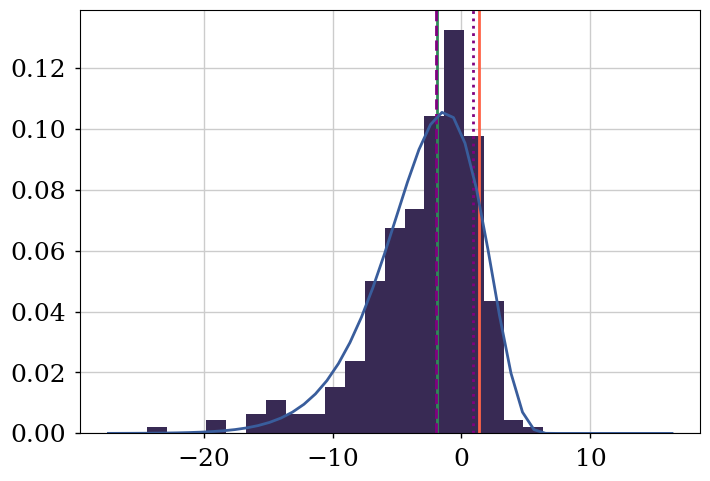

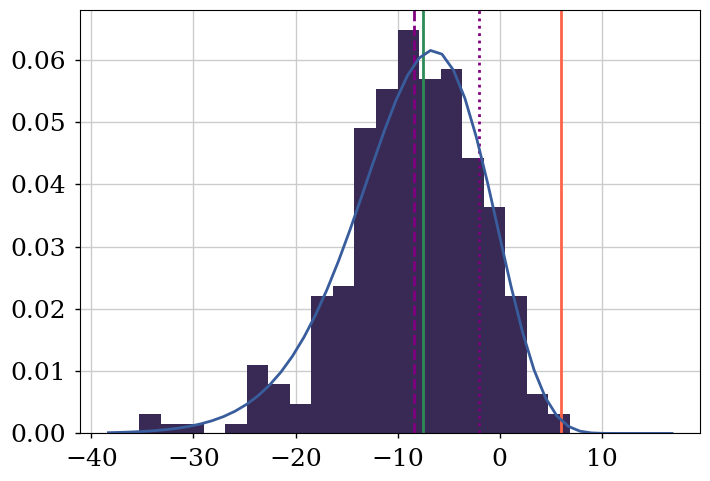

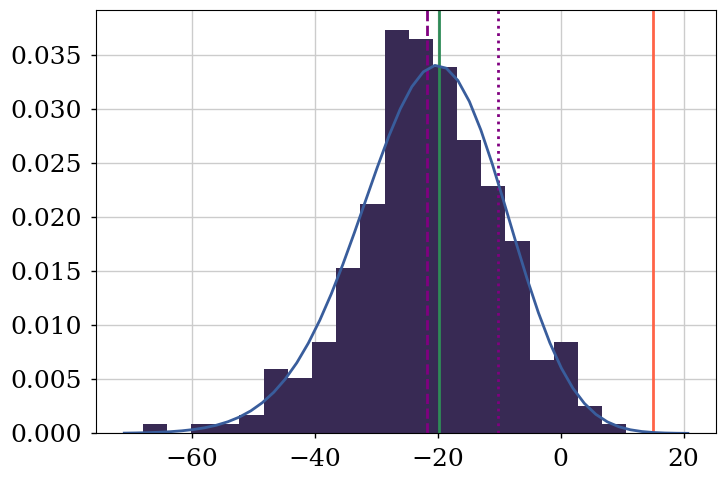

In [179]:
# TS comparison PL (truth) and model
func = gamma
for ident, selection in TS_pl_as_H0_kh.groupby("ident"):
    plt.figure()
    mask = ~selection.TS_PL_model.isna() # & (selection.TS_PL_model > -500)
    plt.hist(selection.TS_PL_model[mask], bins=20, density=True)
    plt.axvline(asimov_fits.TS_PL_model[ident], color="tomato")
    plt.axvline(asimov_fits.TS_PL_model_truthAsimov[ident], color="seagreen")
    plt.axvline(np.median(selection.TS_PL_model[mask]), color="purple", ls="--")
    plt.axvline(
        np.quantile(selection.TS_PL_model[mask], norm.cdf(1)), color="purple", ls=":"
    )
    _fit = func.fit(-selection.TS_PL_model[mask])
    xrange = np.linspace(
        np.min(selection.TS_PL_model[mask]) - 3,
        np.max(selection.TS_PL_model[mask]) + 10,
    )
    plt.plot(xrange, func.pdf(-xrange, *_fit))
    # plt.yscale("log")
    pval = func.cdf(-asimov_fits.TS_PL_model[ident], *_fit)
    print(
        ident,
        1
        - (
            percentileofscore(
                selection.TS_PL_model[mask], asimov_fits.TS_PL_model[ident]
            )
            / 100
        ),
        pval,
        norm.isf(pval),
    )

IceCube 0.10999999999999999
0.1341125248643331
Plenum-1 0.0033333333333334103
0.0021857412233050296
Plenum-2 0.0
0.000204588121345312


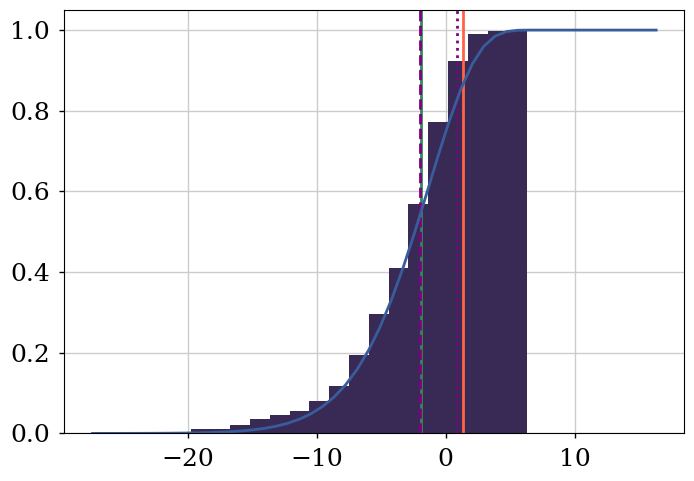

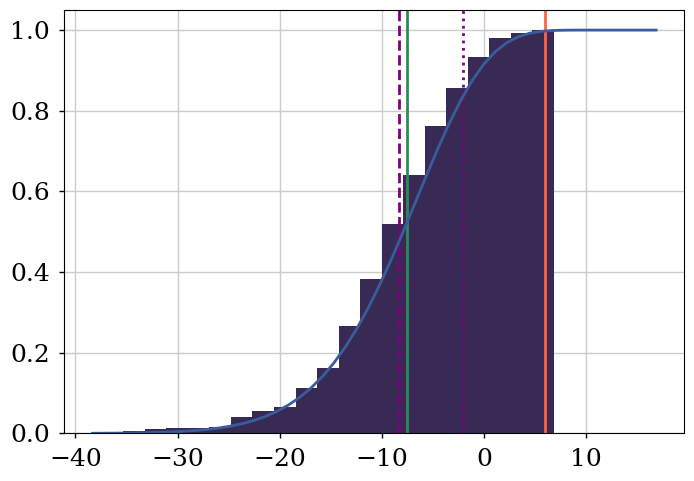

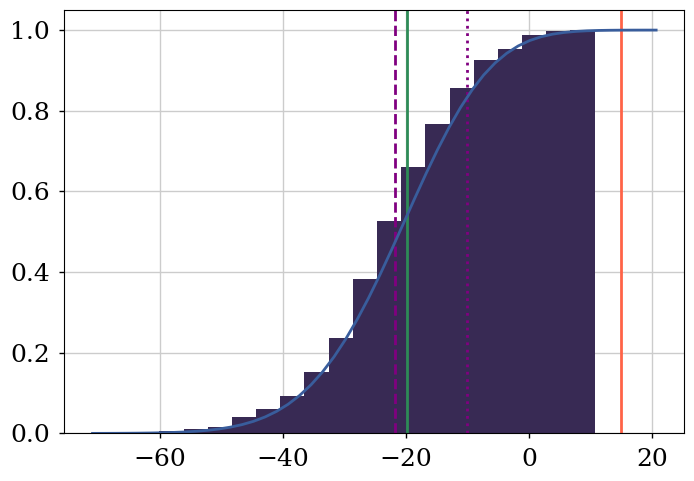

In [180]:
# TS comparison PL (truth) and model
func = gamma
for ident, selection in TS_pl_as_H0_kh.groupby("ident"):
    plt.figure()
    mask = ~selection.TS_PL_model.isna()
    plt.hist(selection.TS_PL_model[mask], bins=20, density=True, cumulative=True)
    plt.axvline(asimov_fits.TS_PL_model[ident], color="tomato")
    plt.axvline(asimov_fits.TS_PL_model_truthAsimov[ident], color="seagreen")
    plt.axvline(np.median(selection.TS_PL_model[mask]), color="purple", ls="--")
    plt.axvline(
        np.quantile(selection.TS_PL_model[mask], norm.cdf(1)), color="purple", ls=":"
    )
    _fit = func.fit(-selection.TS_PL_model[mask])
    xrange = np.linspace(
        np.min(selection.TS_PL_model[mask]) - 3,
        np.max(selection.TS_PL_model[mask]) + 10,
    )
    plt.plot(xrange, func.sf(-xrange, *_fit))
    # plt.yscale("log")
    print(
        ident,
        1
        - (percentileofscore(
            selection.TS_PL_model[mask], asimov_fits.TS_PL_model[ident]
        )
        / 100),
    )
    print(func.cdf(-asimov_fits.TS_PL_model[ident], *_fit))

## spectral fit vs. dec

scan for right threshold

In [42]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in detector_keys:
    conf = st.detector_configurations[ident]

    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_cut_flux,
        )

        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)

        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
            )

            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_sig": np.sum(current_k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(pval),
                "pval": pval
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:24<00:00,  5.54s/it]


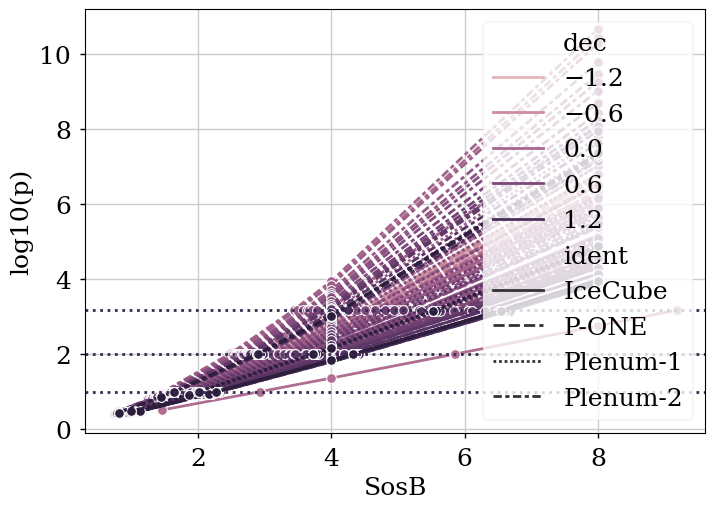

In [43]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB"  # "scaler" #
ax = sns.lineplot(data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


In [44]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()


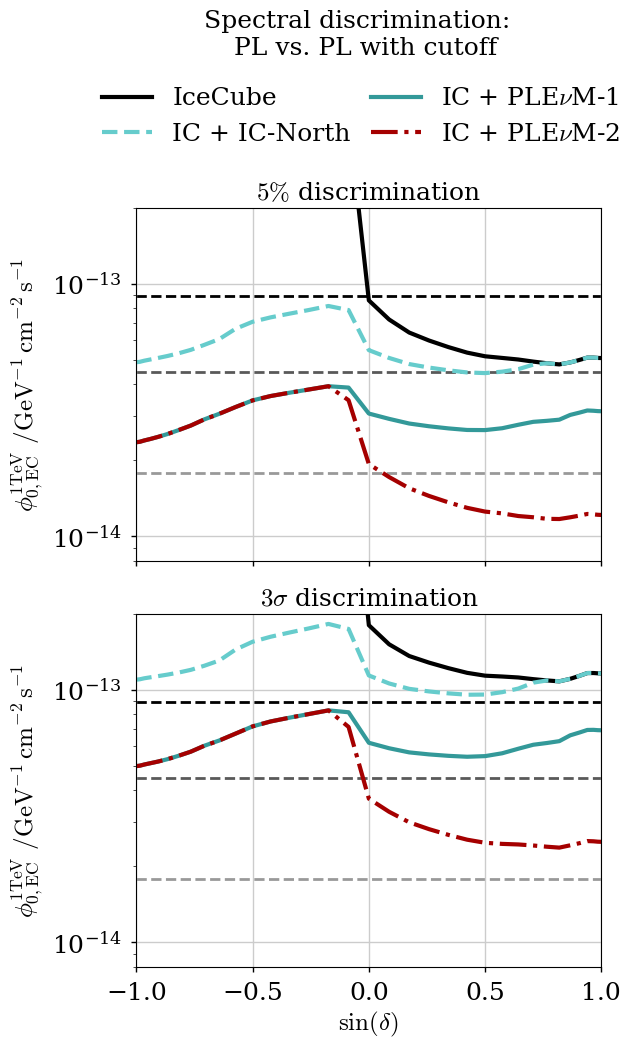

In [45]:

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
)

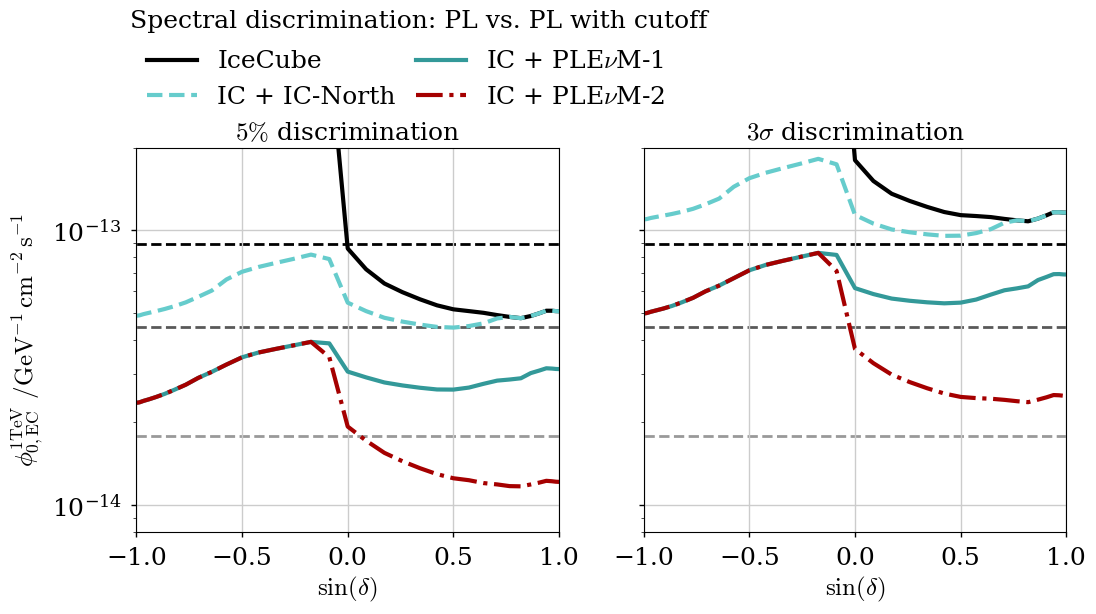

In [46]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r"$\sin(\delta)$", fontsize=18)
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.35, 0.95),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[0].set_ylabel(
    r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=18,
)
f.subplots_adjust(hspace=0.15, top=0.75)
f.suptitle("Spectral discrimination: PL vs. PL with cutoff", fontsize=18, ha="left", x=0.12)
f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot_horizontal.pdf"),
    bbox_inches="tight",
)